Parameter             beta    Significant
-----------  -------------  -------------
A              3.31751e+07    9.91413e+06
Ea           157.558          0.0830598
kd            -0.0799952     -4.04101
Adjusted R-squared:  0.9409658959869057
b:  [ 3.318e+07  1.576e+02 -8.000e-02]


/var/folders/4w/bkdv3bx904ncw2sp853y5wt40000gn/T/ipykernel_22036/1083181505.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b,res,rank,sv=linalg.lstsq(X,y)  # least squares


(array([ 3.318e+07,  1.576e+02, -8.000e-02]),
 array([-15.747, -15.752, -15.758, -15.763, -15.768, -15.774, -15.779,
        -15.784, -15.79 , -15.795, -15.8  , -15.806, -15.811, -15.816,
        -15.822, -15.827, -15.832, -15.838, -15.843, -15.848, -15.854,
        -15.859, -15.864, -15.87 , -15.875, -15.88 , -15.886, -15.891,
        -15.896, -15.902, -15.907, -15.912, -15.918, -15.923, -15.928,
        -15.934, -15.939, -15.944, -15.95 , -15.955, -15.96 , -15.966,
        -15.971, -15.976, -15.982, -15.987, -15.992, -15.998, -16.003,
        -16.008, -16.014, -16.019, -16.024, -16.03 , -16.035, -16.04 ,
        -16.046, -16.051, -16.056, -16.062, -16.067, -16.072, -16.078,
        -16.083, -15.527, -15.532, -15.537, -15.543, -15.548, -15.553,
        -15.559, -15.564, -15.569, -15.575, -15.58 , -15.585, -15.591,
        -15.596, -15.601, -15.607, -15.612, -15.617, -15.623, -15.628,
        -15.633, -15.639, -15.644, -15.649, -15.655, -15.66 , -15.118,
        -15.123, -15.128, -15.1

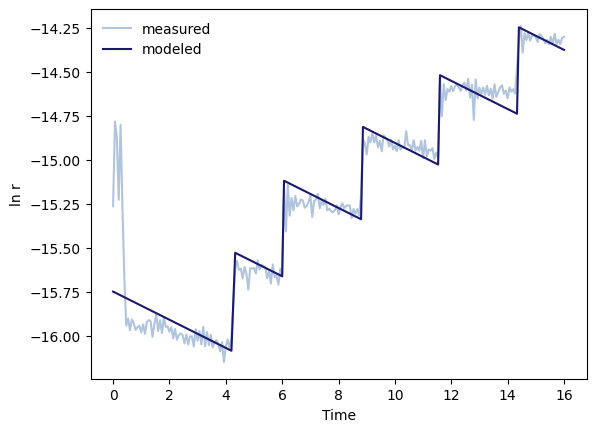

In [63]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.integrate import odeint
import scipy.odr
import scipy
import statistics as st
import math
from matplotlib.pylab import *
from tabulate import tabulate


species=['ketene','ethanol','acetaldehyde','acetone','aceticacid','acetic anhydride','H2O','CO2','N2','H2']
ketene,ethanol,acetaldehyde,acetone,aceticacid,aceticanhydride,h2o,co2,n2,h2=range(10)
M=[42,46,44,58,60,102,18,44,28,2]
C=[2,2,2,3,2,4]
RRF=[0.279,0.279,0.415,0.27,0.56,0.46]

def pp(y,M,P):
    #partial pressure calculations
    Pi=(y/M)/sum(y/M)*P
    return Pi


# Ketene, ethanol, acetaldehyde, acetone, acetic acid, mesityl oxide, mesitylene, isophorone
# Importing data and producing area fraction
skiprowz=2
name='Tekstfiler/Ni_0_50.txt'
A=np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(1,2,3,4,5,6,))
t=(np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(0)))/60 # time in hours
T=np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(7))+273.15 # temperatures in kelvin
H2f,N2f,AAf=np.loadtxt(name,skiprows=skiprowz,unpack=True,usecols=(8,9,10))
t=t-t[0]
gcat=[0.0100]*T.shape[0] #getting gcat as array

H2w=H2f/22400*M[h2] #ml/min til g/min
N2w=N2f/22400*M[n2]
AAw=AAf/1000*1.05   # ml/min -> 1050 mg/ml
WHSV=AAw/gcat*60 
Fin=H2w+N2w+AAw

N2wout=N2w/(H2w+N2w+AAw)
H2wout=H2w/(H2w+N2w+AAw)
AAwout=AAw/(H2w+N2w+AAw)


# convert to w%:
Afrac=A
for i in range(A.shape[1]):
    Afrac[:,i]=A[:,i]/sum(A[:,i])
Afrac=Afrac.transpose()
Wfrac=Afrac*RRF
Mfrac=Wfrac*C*12/M[0:6]
MH2O,MCO2=[np.zeros(A.shape[1])]*2

MH2O=Mfrac[:,0]+Mfrac[:,1]+Mfrac[:,2]+Mfrac[:,3]+1*Mfrac[:,5]
MCO2=Mfrac[:,3]


Mfrac=np.c_[Mfrac,MH2O,MCO2]
W=Mfrac
for i in range(Mfrac.shape[0]):
    W[i,:]=Mfrac[i,:]*M[0:8]/(sum(Mfrac[i,:]*M[0:8]))*AAwout[i]
W=np.c_[W,N2wout,H2wout]

w0=np.zeros([W.shape[0],W.shape[1]])
w0[:,aceticacid],w0[:,h2],w0[:,n2]=AAwout,H2wout,N2wout
Pout=np.zeros([W.shape[0],W.shape[1]])
Pin=np.zeros([W.shape[0],W.shape[1]])
for i in range(W.shape[0]):
    Pout[i,:]=pp(W[i,:],M,1)
    Pin[i,:]=pp(w0[i,:],M,1)

# calculate reaction rates
conversion=(w0[:,aceticacid]-W[:,aceticacid])/w0[:,aceticacid]*100
#print(conversion)
r=np.zeros([W.shape[0],W.shape[1]])
for i in range(r.shape[0]):
    r[i,:]=W[i,:]*Fin[i]/M/gcat[i]*10**6 #micromol/gcat/h
rt=r/10**6/3600 # mol/gcat/s



def arrh_time(T,t,r):
    n = T.size
    y = np.log(r)
    X = np.c_[np.ones(n), 1 / T, t]
    p=X.shape[1]   # number of parameters
    b,res,rank,sv=linalg.lstsq(X,y)  # least squares 
    yhat=np.dot(X, b)
    eps=y-yhat
    SSE = np.dot(eps,eps)  # e.T*e
    MSE =SSE/(n-p)   # alternative MSE = np.var(eps,ddof=p)
    cov= linalg.inv( np.dot(X.T,X) )*MSE
    se_b=np.sqrt(np.diag(cov))
    ymean = np.average(y)
    SST = ((y-ymean)**2).sum()
    SSR = SST - SSE 
    R2 = 1-SSE/SST
    R2_adj = 1-(SSE/(n-p))/(SST/(n-1))
    np.set_printoptions(precision=3)

    b[0]=np.exp(b[0]) # e^ln A
    b[1]=-b[1]*8.314/1000 # Ea, units converted to kJ/mol
    
    tm=stats.t.isf(0.05/2.0,n-p)  # 95% confidence interval fence
    seb=np.sqrt(np.diag(cov))*tm
    q=b
    sig=(b/se_b)/stats.t.ppf(0.975,n-p)
    #T,t,Pout[:,aceticacid],Pout[:,h2],Pout[:,h2o]
    dataa=[[0]*3 for i in range(len(q))]
    pparameter=['A','Ea','kd']

    for i in range(len(pparameter)):
        dataa[i]=[pparameter[i],q[i],sig[i]]

    print(tabulate(dataa, headers=['Parameter','beta','Significant']))

    b=np.array(b)
    print("Adjusted R-squared: ", R2_adj)
    print("b: ", b)

    plt.plot(t,y,label='measured', color='lightsteelblue')
    plt.plot(t,yhat,label='modeled', color='midnightblue')
    plt.ylabel("ln r")
    plt.xlabel("Time")
    plt.legend(frameon=False)

    return b,yhat

arrh_time(T,t, rt[:,acetone])


Filtrering:

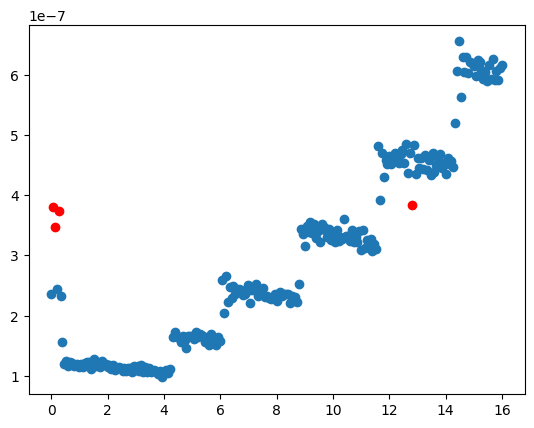

In [64]:
r_T = rt[:,acetone]
T=T
t=t

unique_temperatures = np.unique(T)

T_list = []
t_list = []
r_T_list = []
IDX_list = [] 

for temp in unique_temperatures:
    indices = np.where(T == temp)[0]

    T_temp = T[indices]
    t_temp = t[indices] 
    r_T_temp = r_T[indices]

    #weighted_avg = np.average(r_T_temp, weights=amount)

    mean_rt_acetone = np.mean(r_T_temp)
    std_dev = np.std(r_T_temp)

    lower_threshold = mean_rt_acetone - 3 * std_dev
    upper_threshold = mean_rt_acetone + 3 * std_dev
    
    outlier_indices = (r_T_temp < lower_threshold) | (r_T_temp > upper_threshold)
    #print("Outlier Indices:", outlier_indices)

    T_list.append(T_temp)
    t_list.append(t_temp)
    r_T_list.append(r_T_temp)
    IDX_list.append(outlier_indices)


for t, r_T, idx in zip(t_list, r_T_list, IDX_list):

    plt.scatter(t[idx], r_T[idx], color="red")
    plt.scatter(t[~idx], r_T[~idx], color="tab:blue")

plt.show()

filtered_T_list = []
filtered_t_list = []
filtered_r_T_list = []

for T_temp, t_temp, r_T_temp, outlier_indices in zip(T_list, t_list, r_T_list, IDX_list):
    filtered_T_temp = T_temp[~outlier_indices]
    filtered_t_temp = t_temp[~outlier_indices]
    filtered_r_T_temp = r_T_temp[~outlier_indices]

    filtered_T_list.append(filtered_T_temp)
    filtered_t_list.append(filtered_t_temp)
    filtered_r_T_list.append(filtered_r_T_temp)

r_T_filtered = np.concatenate(filtered_r_T_list)
T_filtered = np.concatenate(filtered_T_list)
t_filtered = np.concatenate(filtered_t_list)




Parameter              beta    Significant
-----------  --------------  -------------
A            336369          161461
Ea              136.16            0.115353
kd               -0.0487608      -3.92837
Adjusted R-squared:  0.9784007091380207
b:  [ 3.364e+05  1.362e+02 -4.876e-02]


/var/folders/4w/bkdv3bx904ncw2sp853y5wt40000gn/T/ipykernel_22036/1083181505.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b,res,rank,sv=linalg.lstsq(X,y)  # least squares


(array([ 3.364e+05,  1.362e+02, -4.876e-02]),
 array([-15.848, -15.858, -15.864, -15.867, -15.871, -15.874, -15.877,
        -15.88 , -15.884, -15.887, -15.89 , -15.893, -15.897, -15.9  ,
        -15.903, -15.906, -15.91 , -15.913, -15.916, -15.919, -15.923,
        -15.926, -15.929, -15.932, -15.936, -15.939, -15.942, -15.945,
        -15.949, -15.952, -15.955, -15.958, -15.962, -15.965, -15.968,
        -15.971, -15.975, -15.978, -15.981, -15.984, -15.988, -15.991,
        -15.994, -15.998, -16.001, -16.004, -16.007, -16.011, -16.014,
        -16.017, -16.02 , -16.024, -16.027, -16.03 , -16.033, -16.037,
        -16.04 , -16.043, -16.046, -16.05 , -16.053, -15.569, -15.573,
        -15.576, -15.579, -15.582, -15.586, -15.589, -15.592, -15.595,
        -15.599, -15.602, -15.605, -15.608, -15.612, -15.615, -15.618,
        -15.621, -15.625, -15.628, -15.631, -15.634, -15.638, -15.641,
        -15.644, -15.647, -15.651, -15.18 , -15.184, -15.187, -15.19 ,
        -15.193, -15.197, -15.2

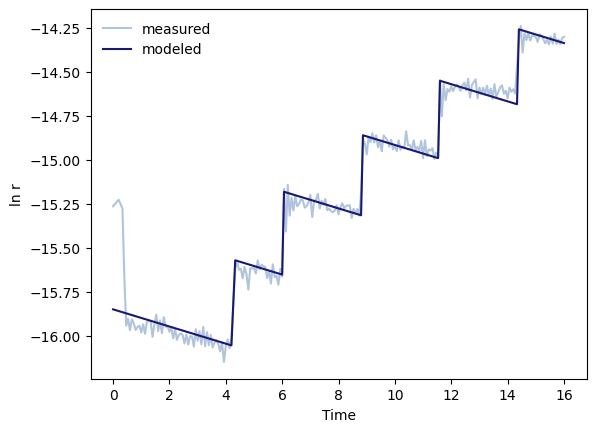

In [65]:
arrh_time(T_filtered,t_filtered,r_T_filtered)

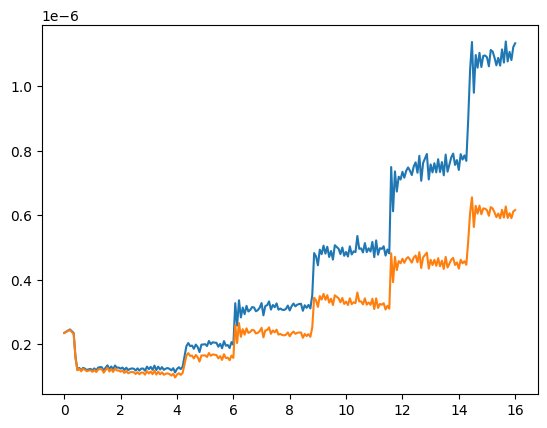

In [66]:
kd=-0.0380579
at=np.exp(kd*t)
filtered_at=np.exp(kd*t_filtered)


plt.plot(t_filtered,r_T_filtered/filtered_at)
plt.plot(t_filtered,r_T_filtered)

In [67]:
h = 6.62607015e-34  # Js
kB = 1.380649e-23   # J/K
R = 8.314           # J/mol

def arrh_time_dS(T,t,r):
    n = T.size
    y = np.log(r/T)
    X = np.c_[np.ones(n), 1 / T, t]
    p=X.shape[1]   # number of parameters
    b,res,rank,sv=linalg.lstsq(X,y)  # least squares 
    yhat=np.dot(X, b)
    eps=y-yhat
    SSE = np.dot(eps,eps)  # e.T*e
    MSE =SSE/(n-p)   # alternative MSE = np.var(eps,ddof=p)
    cov= linalg.inv( np.dot(X.T,X) )*MSE
    se_b=np.sqrt(np.diag(cov))
    ymean = np.average(y)
    SST = ((y-ymean)**2).sum()
    SSR = SST - SSE 
    R2 = 1-SSE/SST
    R2_adj = 1-(SSE/(n-p))/(SST/(n-1))
    np.set_printoptions(precision=3)

    b[0]=(b[0]-np.log(kB/h))*R #J/mol K
    b[1]=-b[1]*R/1000 # kJ/mol

    tm=stats.t.isf(0.05/2.0,n-p)  # 95% confidence interval fence
    seb=np.sqrt(np.diag(cov))*tm
    q=b
    sig=(b/se_b)/stats.t.ppf(0.975,n-p)
    #T,t,Pout[:,aceticacid],Pout[:,h2],Pout[:,h2o]
    dataa=[[0]*3 for i in range(len(q))]
    pparameter=['dS','dH','kd']

    for i in range(len(pparameter)):
        dataa[i]=[pparameter[i],q[i],sig[i]]

    print(tabulate(dataa, headers=['Parameter','beta','Significant']))

    b=np.array(b)
    print("Adjusted R-squared: ", R2_adj)

    """plt.plot(t,y,label='measured', color='lightsteelblue')
    plt.plot(t,yhat,label='modeled', color='midnightblue')
    plt.ylabel("ln r/T")
    plt.xlabel("Time")
    plt.legend(frameon=False)"""

    print('b: ', b)

    return b,yhat

arrh_time_dS(T_filtered,t_filtered,r_T_filtered)




Parameter            beta    Significant
-----------  ------------  -------------
dS           -153.143         -73.519
dH            131.228           0.111188
kd             -0.0487819      -3.93054
Adjusted R-squared:  0.9761264484209793
b:  [-1.531e+02  1.312e+02 -4.878e-02]


/var/folders/4w/bkdv3bx904ncw2sp853y5wt40000gn/T/ipykernel_22036/3907421294.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b,res,rank,sv=linalg.lstsq(X,y)  # least squares


(array([-1.531e+02,  1.312e+02, -4.878e-02]),
 array([-22.199, -22.209, -22.215, -22.218, -22.222, -22.225, -22.228,
        -22.231, -22.235, -22.238, -22.241, -22.244, -22.248, -22.251,
        -22.254, -22.257, -22.261, -22.264, -22.267, -22.27 , -22.274,
        -22.277, -22.28 , -22.283, -22.287, -22.29 , -22.293, -22.296,
        -22.3  , -22.303, -22.306, -22.309, -22.313, -22.316, -22.319,
        -22.322, -22.326, -22.329, -22.332, -22.335, -22.339, -22.342,
        -22.345, -22.348, -22.352, -22.355, -22.358, -22.361, -22.365,
        -22.368, -22.371, -22.374, -22.378, -22.381, -22.384, -22.387,
        -22.391, -22.394, -22.397, -22.4  , -22.404, -21.938, -21.941,
        -21.944, -21.948, -21.951, -21.954, -21.957, -21.961, -21.964,
        -21.967, -21.97 , -21.974, -21.977, -21.98 , -21.983, -21.987,
        -21.99 , -21.993, -21.996, -22.   , -22.003, -22.006, -22.009,
        -22.013, -22.016, -22.019, -21.566, -21.569, -21.573, -21.576,
        -21.579, -21.582, -21.5

In [68]:
b=[ 2.423e-02, -1.305e+04, -3.813e-02]

dS=R*(b[0]-np.log(kB/h))

print(dS)

-197.33900729653206
